# Ajuste paramétrico con el modelo SIR de epidemias

In [18]:
import Pkg; Pkg.add("ForwardDiff")
import Pkg; Pkg.add("OrdinaryDiffEq")
import Pkg; Pkg.add("Optim")

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.11/Project.toml`
  No Changes to `~/.julia/environments/v1.11/Manifest.toml`


In [19]:
using Plots
using ForwardDiff
using OrdinaryDiffEq
using LinearAlgebra
using Optim

<a href="#top">Hasierara</a>


## 1 - Modelo SIR

Aquí tienes la traducción al español:

---

Aquí trabajaremos con el modelo determinista clásico SIR de W. O. Kermack y A. G. McKendrick (1927). [Enlace:](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology)

Dividiremos una población dada en tres grupos en todo momento. Las poblaciones de estos tres grupos serán respectivamente $S$, $I$ y $R$:  

- $S$, la cantidad de individuos que no han tenido contacto con el virus. A medida que avanza el tiempo durante una epidemia, este número disminuirá.  
- $I$, la cantidad de personas que tienen el virus en su organismo y son capaces de contagiarlo.  
- $R$, la cantidad de individuos que han tenido contacto con el virus en el pasado y ya no son capaces de contagiarlo.  

Mediremos el tiempo ($t$) en días.  

En este modelo simplificado, se supone que las variables de estado $S$, $I$ y $R$ satisfacen el siguiente sistema de ecuaciones diferenciales:

\begin{align*}
\frac{d}{dt} S &= -\frac{\beta}{N}\, S\, I, \\
\frac{d}{dt} I &= \frac{\beta}{N}\, S\, I - \gamma\, I, \\
\frac{d}{dt} R &= \gamma\, I.
\end{align*}

Este sistema tiene los siguientes parámetros constantes:

- $\gamma>0$. Se puede decir que el tiempo promedio necesario para pasar del estado de infectado al grupo $R$ es $\gamma^{-1}$.  
- $\beta>0$. Cuanto más contagioso sea el virus, mayor será el valor de $\beta$.  
- $N = S + I + R$, la población total, que se mantiene constante a lo largo del tiempo. Para demostrar que esto se mantiene constante, sumamos todas las ecuaciones del sistema de ecuaciones diferenciales anterior:  

\begin{align*}
\frac{d}{dt} S +  \frac{d}{dt} I + \frac{d}{dt} R \equiv 0.
\end{align*}

Por lo tanto, $N=S + I + R$ se mantiene constante.  

Teniendo esto en cuenta, la variable de estado $S$ puede expresarse en función de las otras dos. Así, el modelo SIR se puede escribir como un sistema de dos variables de estado:

\begin{equation*}
\begin{split}
\frac{d}{dt} I &= \beta\, \left(1 -\alpha \, (I + R)\right)\, I- \gamma\, I, \\
\frac{d}{dt} R &= \gamma\, I,
\end{split} \tag{1}
\end{equation*}

donde $\alpha= 1/N$.

Representaremos dicho sistema de forma compacta de esta forma:

\begin{equation*}
\frac{d u}{dt} = f(t,u,p), \tag{2}
\end{equation*}

sonde $u=(I, R)$ y $p=(\alpha,\beta,\gamma)$.

In [24]:
function SIR!(du,u,p,t)
    I=u[1]
    R=u[2]
    alpha = abs(p[1])
    beta = abs(p[2])
    gamma = abs(p[3])
    du[1] = (beta - gamma - beta*alpha*(I+R))*I
    du[2] = gamma*I
    
    return nothing
end

SIR! (generic function with 1 method)

In [25]:
alpha = 0.001
beta = 0.6
gamma = 0.25
I0  = 97.64285714285734
p0 = [alpha,beta,gamma]
u0 = [I0, 0.]

2-element Vector{Float64}:
 97.64285714285734
  0.0

### 1.2 - Resolución numérica del problema de valor inicial

In [26]:
tend = Float64(61)
tspan = (0.,tend)
prob = ODEProblem( SIR!, u0, tspan, p0 )

h = 1/32
sol = solve(prob, RK4(), adaptive=false, dt=h ,save_everystep=true )

sol.u[end]

2-element Vector{Float64}:
   0.023898779831629285
 894.5386881756442

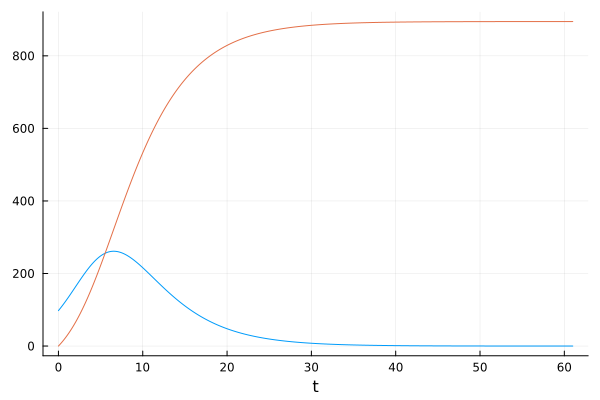

In [27]:
II = [u[1] for u in sol.u]
RR = [u[2] for u in sol.u]
plot(sol.t, II, legend=false, xlabel="t")
plot!(sol.t, RR)

<a href="#top">Hasierara</a>


## 2 - Ajuste paramétrico del modelo SIR

EAE-ko 2021-eko udarako COVID-19-ren kasu positiboen datuak hartuko ditugu kontutan, zehazki, 17-18 adin tarteko gazteen gaineko datuak.

In [28]:
acum_r = [7154, 7280, 7403, 7543, 7730, 7944, 8205, 8444, 8628, 8757, 8885, 9031, 9202, 9364, 9456, 9552, 9626, 9715, 9790, 9881, 9949, 10021, 10081, 10123, 10148, 10188, 10240, 10295, 10358, 10410, 10451, 10497, 10528, 10564, 10598, 10642, 10669, 10705, 10722, 10749, 10781, 10806, 10828, 10858, 10873, 10888, 10903, 10925, 10937, 10952, 10960, 10964, 10971, 10975, 10978, 10983, 10988, 10994, 11000, 11002, 11004, 11008]
acum_s = [7212.387755102041, 7340.7142857142835, 7484.102040816326, 7641.591836734694, 7811.551020408164, 7990.693877551021, 8175.408163265306, 8360.142857142857, 8539.204081632652, 8709.612244897959, 8870.122448979591, 9020.183673469388, 9159.183673469388, 9286.367346938776, 9401.836734693878, 9508.183673469388, 9606.469387755102, 9697.16326530612, 9779.755102040817, 9854.979591836734, 9923.673469387755, 9987.489795918369, 10046.653061224491, 10101.73469387755, 10153.367346938774, 10203.285714285714, 10252.020408163267, 10300.04081632653, 10347.18367346939, 10393.244897959183, 10437.877551020409, 10481.0, 10521.591836734693, 10559.755102040815, 10595.73469387755, 10629.775510204083, 10661.816326530612, 10692.42857142857, 10721.285714285714, 10748.938775510203, 10775.224489795919, 10800.020408163266, 10823.244897959183, 10845.204081632652, 10865.38775510204, 10884.0, 10900.918367346938, 10916.163265306122, 10929.551020408162, 10941.204081632652, 10951.061224489795, 10959.530612244896, 10966.87755102041, 10973.163265306122, 10978.57142857143, 10983.510204081633, 10988.061224489795, 10992.408163265307, 10996.57142857143, 11000.38775510204, 11003.95918367347, 11007.30612244898]
II_r = [107, 126, 123, 140, 187, 214, 261, 239, 184, 129, 128, 146, 171, 162, 92, 96, 74, 89, 75, 91, 68, 72, 60, 42, 25, 40, 52, 55, 63, 52, 41, 46, 31, 36, 34, 44, 27, 36, 17, 27, 32, 25, 22, 30, 15, 15, 15, 22, 12, 15, 8, 4, 7, 4, 3, 5, 5, 6, 6, 2, 2, 4]
II_s = [121.13265306122366, 135.8571428571422, 150.43877551020523, 163.724489795919, 174.55102040816337, 181.9285714285711, 184.7244897959181, 181.8979591836728, 174.73469387755085, 165.45918367346985, 155.28571428571468, 144.5306122448983, 133.09183673469397, 121.32653061224482, 110.90816326530603, 102.31632653061206, 94.48979591836633, 86.64285714285779, 78.90816326530694, 71.95918367346894, 66.25510204081729, 61.489795918368145, 57.122448979590445, 53.3571428571413, 50.77551020408191, 49.32653061224664, 48.377551020407736, 47.581632653061206, 46.602040816326735, 45.34693877550944, 43.877551020408646, 41.85714285714221, 39.377551020407736, 37.07142857142844, 35.010204081633674, 33.04081632653106, 31.326530612243914, 29.734693877550853, 28.255102040816382, 26.969387755102616, 25.540816326531058, 24.010204081631855, 22.59183673469306, 21.07142857142844, 19.397959183674175, 17.765306122449147, 16.081632653061206, 14.31632653061206, 12.52040816326462, 10.755102040816382, 9.163265306122412, 7.908163265307849, 6.816326530612969, 5.846938775509443, 5.173469387755176, 4.744897959182708, 4.448979591837087, 4.255102040817292, 3.989795918366326, 3.693877551020705, 3.459183673469852, 3.193877551018886]
dias = [0:61]
ticks_x = (1:12:62, ["2021/07/15", "2021/07/27", "2021/08/08", "2021/08/20", "2021/09/01", "2021/09/13"])


(1:12:61, ["2021/07/15", "2021/07/27", "2021/08/08", "2021/08/20", "2021/09/01", "2021/09/13"])

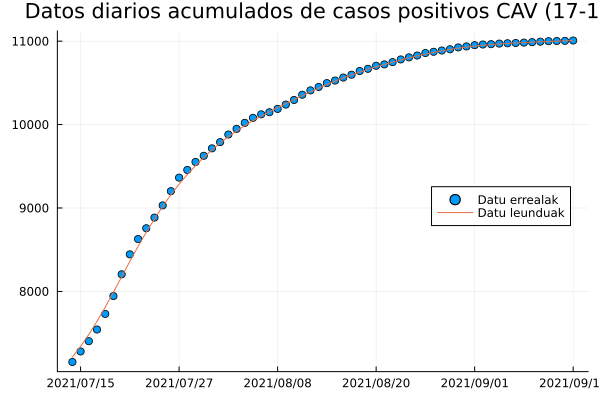

In [29]:
plot(title="Datos diarios acumulados de casos positivos CAV (17-18)", 
     xticks = ticks_x, 
     legend=:right)

scatter!(dias, acum_r, label="Datu errealak")  
plot!(dias, acum_s, label="Datu leunduak")

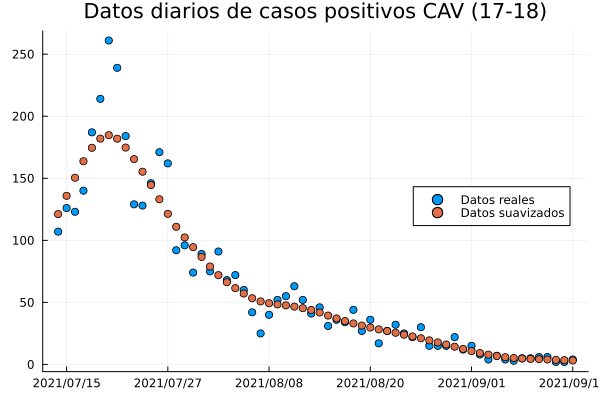

In [30]:
plot(title="Datos diarios de casos positivos CAV (17-18)", 
     xticks = ticks_x, legend=:right)

scatter!(dias, II_r, label="Datos reales")  



scatter!(dias, II_s, label="Datos suavizados")

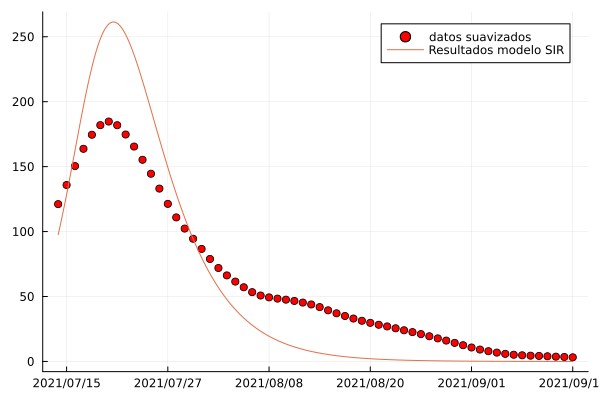

In [33]:
scatter(dias,II_s, color="red", xticks=ticks_x, label="datos suavizados")
plot!(sol.t,II, label="Resultados modelo SIR")

In [112]:
n_dias = 10
h = 1/32

u0 = zeros(2)
p = zeros(3)
function g(X)
    u0[1] = abs( X[1] )
    u0[2] = abs( X[2] )
    
    p[1]  = abs( X[3] ) 
    p[2]  = abs( X[4] )
    p[3]  = abs( X[5] ) # alpha, beta, gamma
    
    prob = ODEProblem(SIR!, u0, (0., Float64(n_dias-1)), p)
    sol = solve(prob, RK4(), adaptive = false, dt = h, saveat = 1.)
    # prob = ODEProblem( SIR!, u0, tspan, p0 )
    # sol = solve(prob, RK4(), adaptive = false, dt = h , save_everystep=true )
    suma = 0.0
    for j in 1:n_dias
        II_ = sol.u[j][1]
        diff = II_s[j] - II_
        suma = suma + diff^2
    end        
    return suma
end


g (generic function with 1 method)

In [113]:
I0  = Float64(II_s[1])
alpha = 0.001
beta = 0.6
gamma = 0.25

X0 = [I0, 0., alpha, beta, gamma]
res = optimize(g, X0, iterations = 100000)

 * Status: success

 * Candidate solution
    Final objective value:     2.662821e+00

 * Found with
    Algorithm:     Nelder-Mead

 * Convergence measures
    √(Σ(yᵢ-ȳ)²)/n ≤ 1.0e-08

 * Work counters
    Seconds run:   5  (vs limit Inf)
    Iterations:    58960
    f(x) calls:    92469


In [114]:
X_opt = res.minimizer

u0 = zeros(2)
p = zeros(3)

u0[1] = X_opt[1]
u0[2] = X_opt[2]

p[1]  = X_opt[3] 
p[2]  = X_opt[4]
p[3]  = X_opt[5] 

prob = ODEProblem(SIR!, u0, (0.,tend), p)
sol  = solve(prob, RK4(), adaptive=false, dt = h, save_everystep=true);

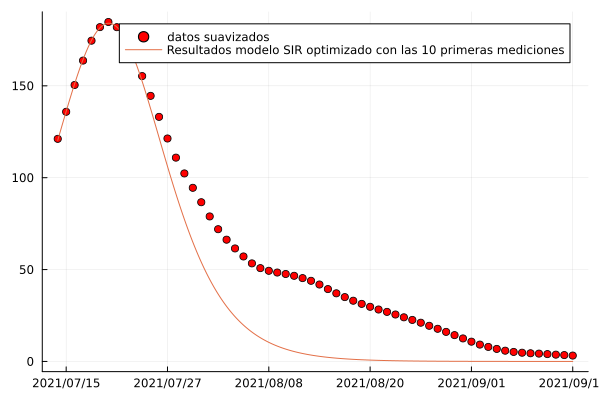

In [115]:
II_opt = [ u[1] for u in sol.u]

scatter(dias,II_s, color="red", xticks=ticks_x, label="datos suavizados")
plot!(sol.t, II_opt, label="Resultados modelo SIR optimizado con las 10 primeras mediciones")

In [116]:
g(X_opt)

2.6628212526094255

In [117]:
X_opt

5-element Vector{Float64}:
   120.34480689122466
 -1002.8646287601531
     2.1729451406543828e-11
  2496.5323192765454
  2496.4010053114057

In [118]:
ForwardDiff.gradient(g, X_opt)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{typeof(g), Float64}, Float64, 5})
The type `Float64` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat
[0m[90m   @[39m [90mBase[39m [90m[4mrounding.jl:265[24m[39m
[0m  (::Type{T})(::T) where T<:Number
[0m[90m   @[39m [90mCore[39m [90m[4mboot.jl:900[24m[39m
[0m  Float64([91m::UInt8[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:245[24m[39m
[0m  ...


In [105]:
# Optimize with gradient
function gradg!(G,x)
    ForwardDiff.gradient!(G,g,x)
    return nothing
end

I0  = II_s[1]
alpha = 0.001
beta = 0.6
gamma = 0.25

X0 = [I0, 0., alpha, beta, gamma]
res_g = optimize(g, gradg!, X0)

LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{typeof(g), Float64}, Float64, 5})
The type `Float64` exists, but no method is defined for this combination of argument types when trying to construct it.

[0mClosest candidates are:
[0m  (::Type{T})(::Real, [91m::RoundingMode[39m) where T<:AbstractFloat
[0m[90m   @[39m [90mBase[39m [90m[4mrounding.jl:265[24m[39m
[0m  (::Type{T})(::T) where T<:Number
[0m[90m   @[39m [90mCore[39m [90m[4mboot.jl:900[24m[39m
[0m  Float64([91m::UInt8[39m)
[0m[90m   @[39m [90mBase[39m [90m[4mfloat.jl:245[24m[39m
[0m  ...


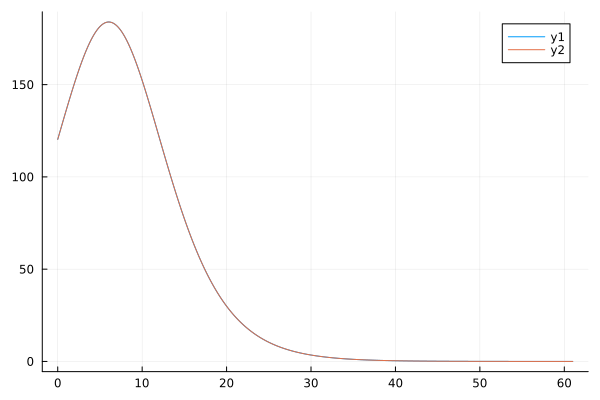

In [132]:
# La h es suficientemente pequeña
h1 = 1/32
sol1 = solve(prob, RK4(), adaptive=false, dt=h1, save_everystep=true )
II_1 = [ u[1] for u in sol1.u]
plot(sol1.t, II_1)

h2 = 1/64
sol2 = solve(prob, RK4(), adaptive=false, dt=h2 , save_everystep=true )
II_2 = [ u[1] for u in sol2.u]
plot!(sol2.t, II_2)


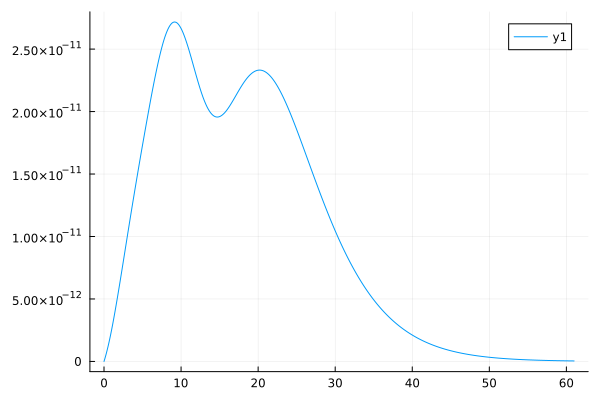

In [137]:
# La h es suficientemente pequeña
h1 = 1/32
sol1 = solve(prob, RK4(), adaptive=false, dt=h1, save_everystep=true )

h2 = 1/64
sol2 = solve(prob, RK4(), adaptive=false, dt=h2 , saveat = h1 )

II_1 = [ u[1] for u in sol1.u] # aproximación "mala"
II_2 = [ u[1] for u in sol2.u] # aproximación "buena"


factor = 1 / 15 # 1 / (2^r - 1) donde r es el rango de rungekuta o el metodo utilizado
errI = factor * (II_1 - II_2)

plot(sol1.t, errI) # los errores de discretización sin muy pequeños con h=1/32
